In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

from matplotlib import rc
from statsmodels.stats.multicomp import MultiComparison
from tools import *

%matplotlib inline
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_context('notebook')

In [2]:
def load_data(files):
    import json
    rv = list()
    for filename in files:
        with open(filename, 'r') as infile:
            rv += json.load(infile)

    # clean up data to fit assumptions
    EPS = 1e-9
    for entry in rv:
        entry['auc'] = sum(entry['accuracy'])
        entry['final_accuracy'] = entry['accuracy'][-1]
        entry['lambda_'] = entry['lambda']  # pandas doesn't allow for columns to be called lambda
        del entry['lambda']
        if entry['approximator'] == 'constant':
            entry['optimizer'] = 'constant'  # rest of plotting relies on optimizer being defined
        if (entry['optimizer'] == 'sgd') and (abs(float(entry['momentum'])) > EPS):
            entry['optimizer'] = 'momentum'  # separate sgd with and without momentum

    to_delete = list()
    constant_seeds = set()
    for i in range(len(rv)):
        if rv[i]['approximator'] == 'constant':
            if rv[i]['env_seed'] in constant_seeds:
                to_delete.append(i)
            else:
                constant_seeds.add(rv[i]['env_seed'])
    for i in reversed(to_delete):
        del rv[i]

    # return cleaned data
    return rv

def get_summary(data):
    temp = dict()
    for entry in data:
        key = get_hyperparameter_key(entry)
        if key in temp:
            temp[key].append(entry['auc'])
        else:
            temp[key] = [entry['auc']]
    auc_table = list()
    for key, value in temp.items():
        entry = dict(key._asdict())
        entry['count'] = len(value)
        entry['auc_mean'] = np.mean(value)
        entry['auc_stderr'] = np.std(value) / np.sqrt(len(value))
        entry['final_accuracy_mean'] = np.mean(value)
        entry['final_accuracy_stderr'] = np.std(value) / np.sqrt(len(value))
        auc_table.append(entry)
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(auc_table))

def get_best(data, metric, summary=None):
    if summary is None:
        summary = get_summary(data)
    assert(metric in ['auc', 'final_accuracy'])

    # build best table
    best = list()
    for optimizer in summary['optimizer'].unique():
        sub_table = summary[summary['optimizer'] == optimizer]
        best.append((sub_table.loc[sub_table['{}_mean'.format(metric)].idxmin()]).to_dict())
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(best))

def get_best_by_optimizer(data, best_auc_table=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))

    # build best by optimizer dict
    best_keys = {row['optimizer']: get_hyperparameter_key(row.to_dict()) for _, row in best_auc_table.iterrows()}
    rv = dict()
    for entry in data:
        optimizer = entry['optimizer']
        if get_hyperparameter_key(entry) == best_keys[optimizer]:
            if optimizer not in rv:
                rv[optimizer] = [entry]
            else:
                rv[optimizer].append(entry)
    return rv

def get_best_by_optimizer_summary(data, best_auc_table=None, best_by_optimizer=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))
    if best_by_optimizer is None:
        best_by_optimizer = get_best_by_optimizer(data, best_auc_table)

    # build best by optimizer summary dict
    rv = {row['optimizer']: row.to_dict() for _, row in best_auc_table.iterrows()}
    for key1 in rv.keys():
        for key2 in result_labels:
            try:
                values = np.array([item[key2] for item in best_by_optimizer[key1]])
                rv[key1][key2 + '_mean'] = np.mean(values, axis=0)
                rv[key1][key2 + '_stderr'] = np.std(values, axis=0) / np.sqrt(values.shape[0])
            except TypeError:
                pass
    return rv

optimizer_nice_names = {'constant': 'Constant', 'adam': 'Adam', 'momentum': 'Momentum', 'rms': 'RMSProp', 'sgd': 'SGD'}

# Train

In [3]:
data = load_data(['2020-05-27T11:49:59.282276-04:00.json'])
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr,final_accuracy_mean,final_accuracy_stderr
0,neural_network,NaN,NaN,None,TD,0.000061,NaN,rms,0.99,1.0,50,24119.047140,50.905453,24119.047140,50.905453
1,neural_network,NaN,NaN,None,TD,0.000122,0.81,momentum,NaN,1.0,50,17392.993333,65.882244,17392.993333,65.882244
2,neural_network,NaN,NaN,None,TD,0.000488,0.00,sgd,NaN,1.0,50,17762.734792,67.549402,17762.734792,67.549402
3,neural_network,0.9,0.999,None,TD,0.031250,NaN,adam,NaN,1.0,50,17174.910129,104.855573,17174.910129,104.855573
4,constant,NaN,NaN,None,None,NaN,NaN,constant,NaN,NaN,50,19725.857984,3.167172,19725.857984,3.167172


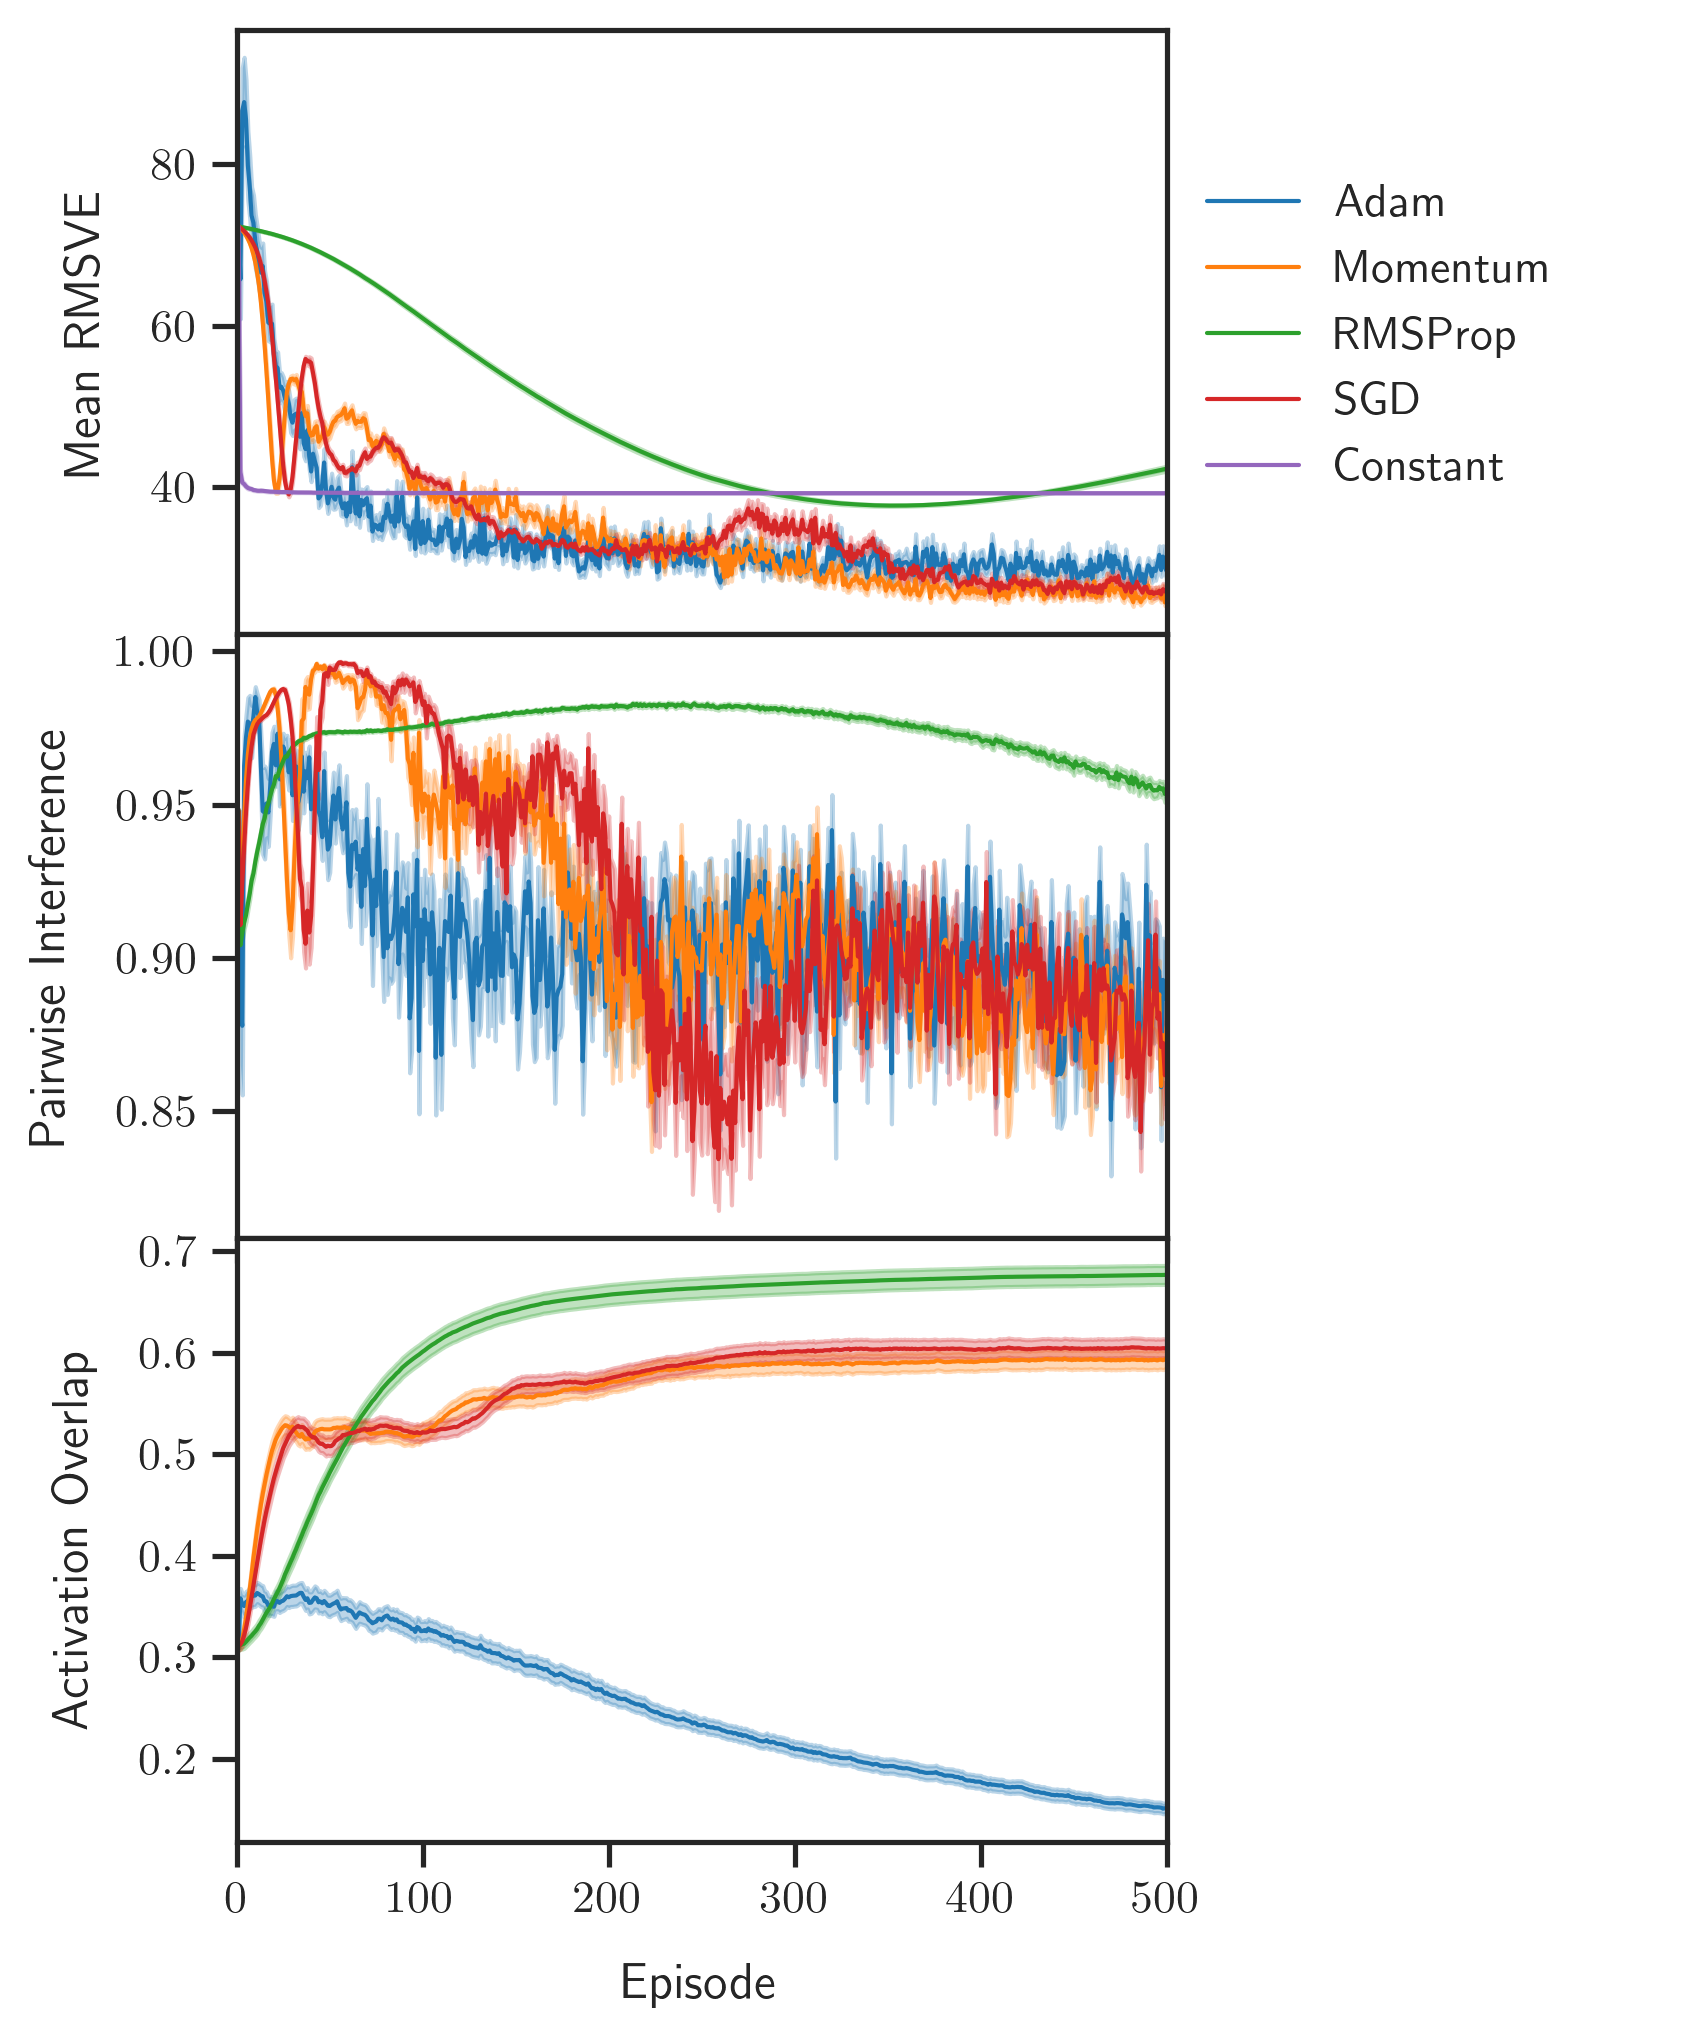

In [4]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer_nice_names[optimizer],
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.79), frameon=False)
fig.subplots_adjust(hspace=0.0)

## SGD with Momentum

In [5]:
data = load_data(['2020-05-27T11:49:59.282276-04:00.json'])
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'momentum':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['momentum']
for i in reversed(to_delete):
    del data[i]
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr,final_accuracy_mean,final_accuracy_stderr
0,neural_network,None,None,None,TD,0.000061,0.90,0.90,None,1,50,17476.002486,64.786270,17476.002486,64.786270
1,neural_network,None,None,None,TD,0.000122,0.81,0.81,None,1,50,17392.993333,65.882244,17392.993333,65.882244
2,neural_network,None,None,None,TD,0.000004,0.99,0.99,None,1,50,21135.782831,267.404531,21135.782831,267.404531


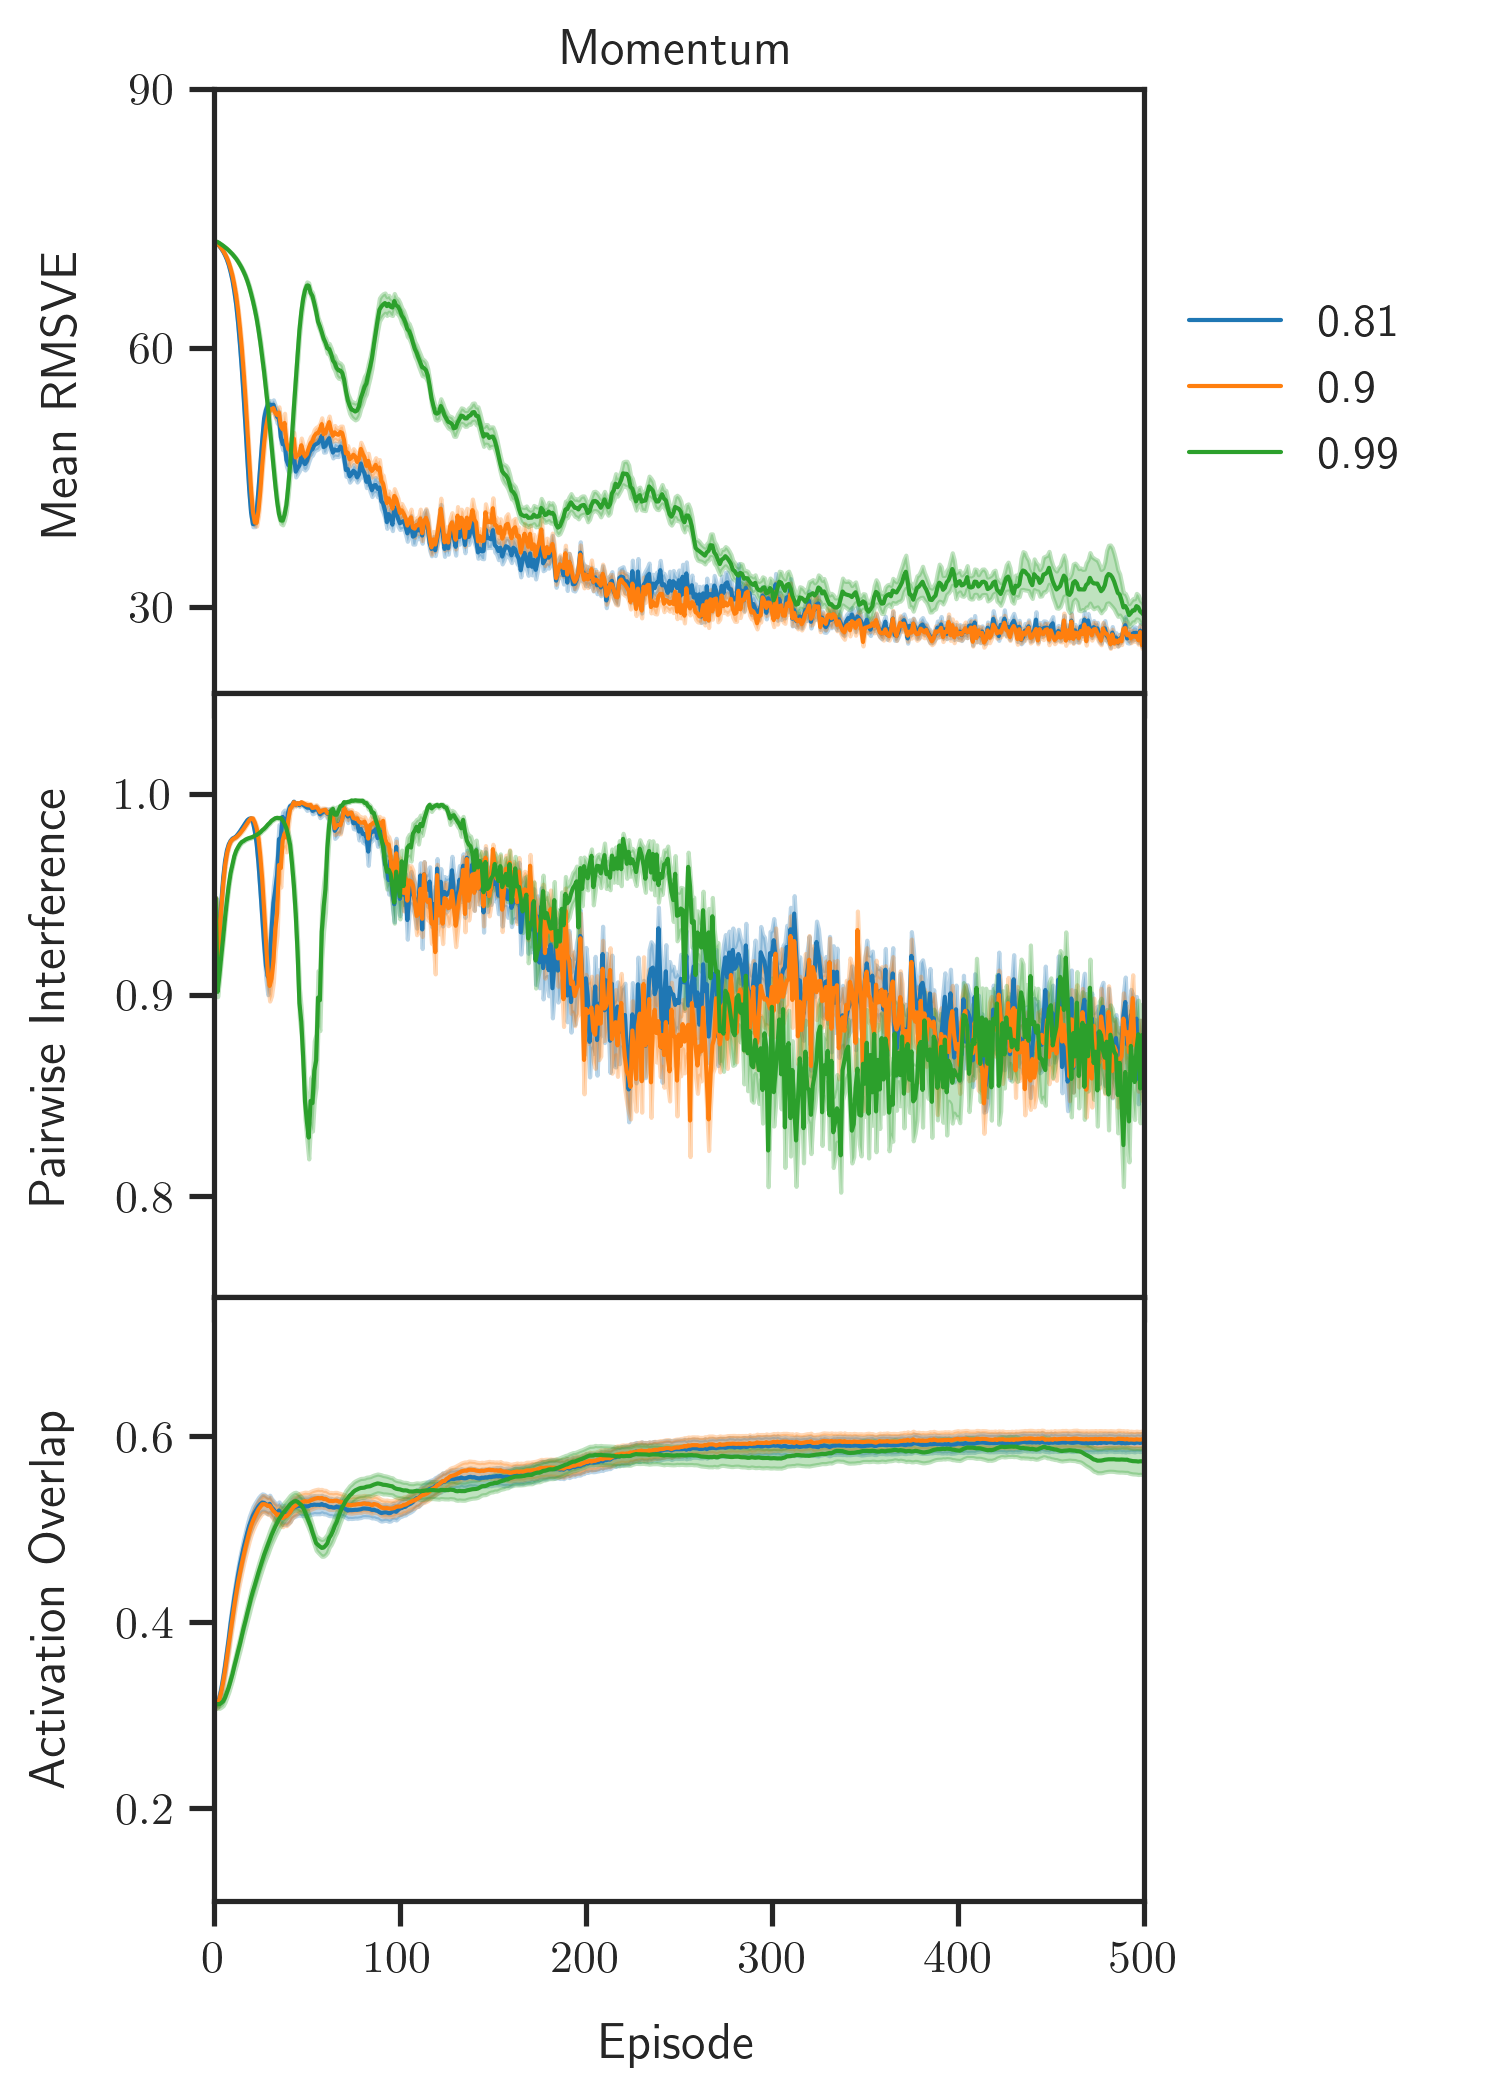

In [6]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('Momentum')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.20, 0.765), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('mountain_car_momentum_results.pdf', bbox_inches='tight')

## RMSProp

In [7]:
data = load_data(['2020-05-27T11:49:59.282276-04:00.json'])
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'rms':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['rho']
for i in reversed(to_delete):
    del data[i]
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr,final_accuracy_mean,final_accuracy_stderr
0,neural_network,None,None,None,TD,0.000031,None,0.81,0.81,1,50,28102.008917,81.426387,28102.008917,81.426387
1,neural_network,None,None,None,TD,0.000061,None,0.90,0.90,1,50,27730.405245,148.317448,27730.405245,148.317448
2,neural_network,None,None,None,TD,0.000061,None,0.99,0.99,1,50,24119.047140,50.905453,24119.047140,50.905453


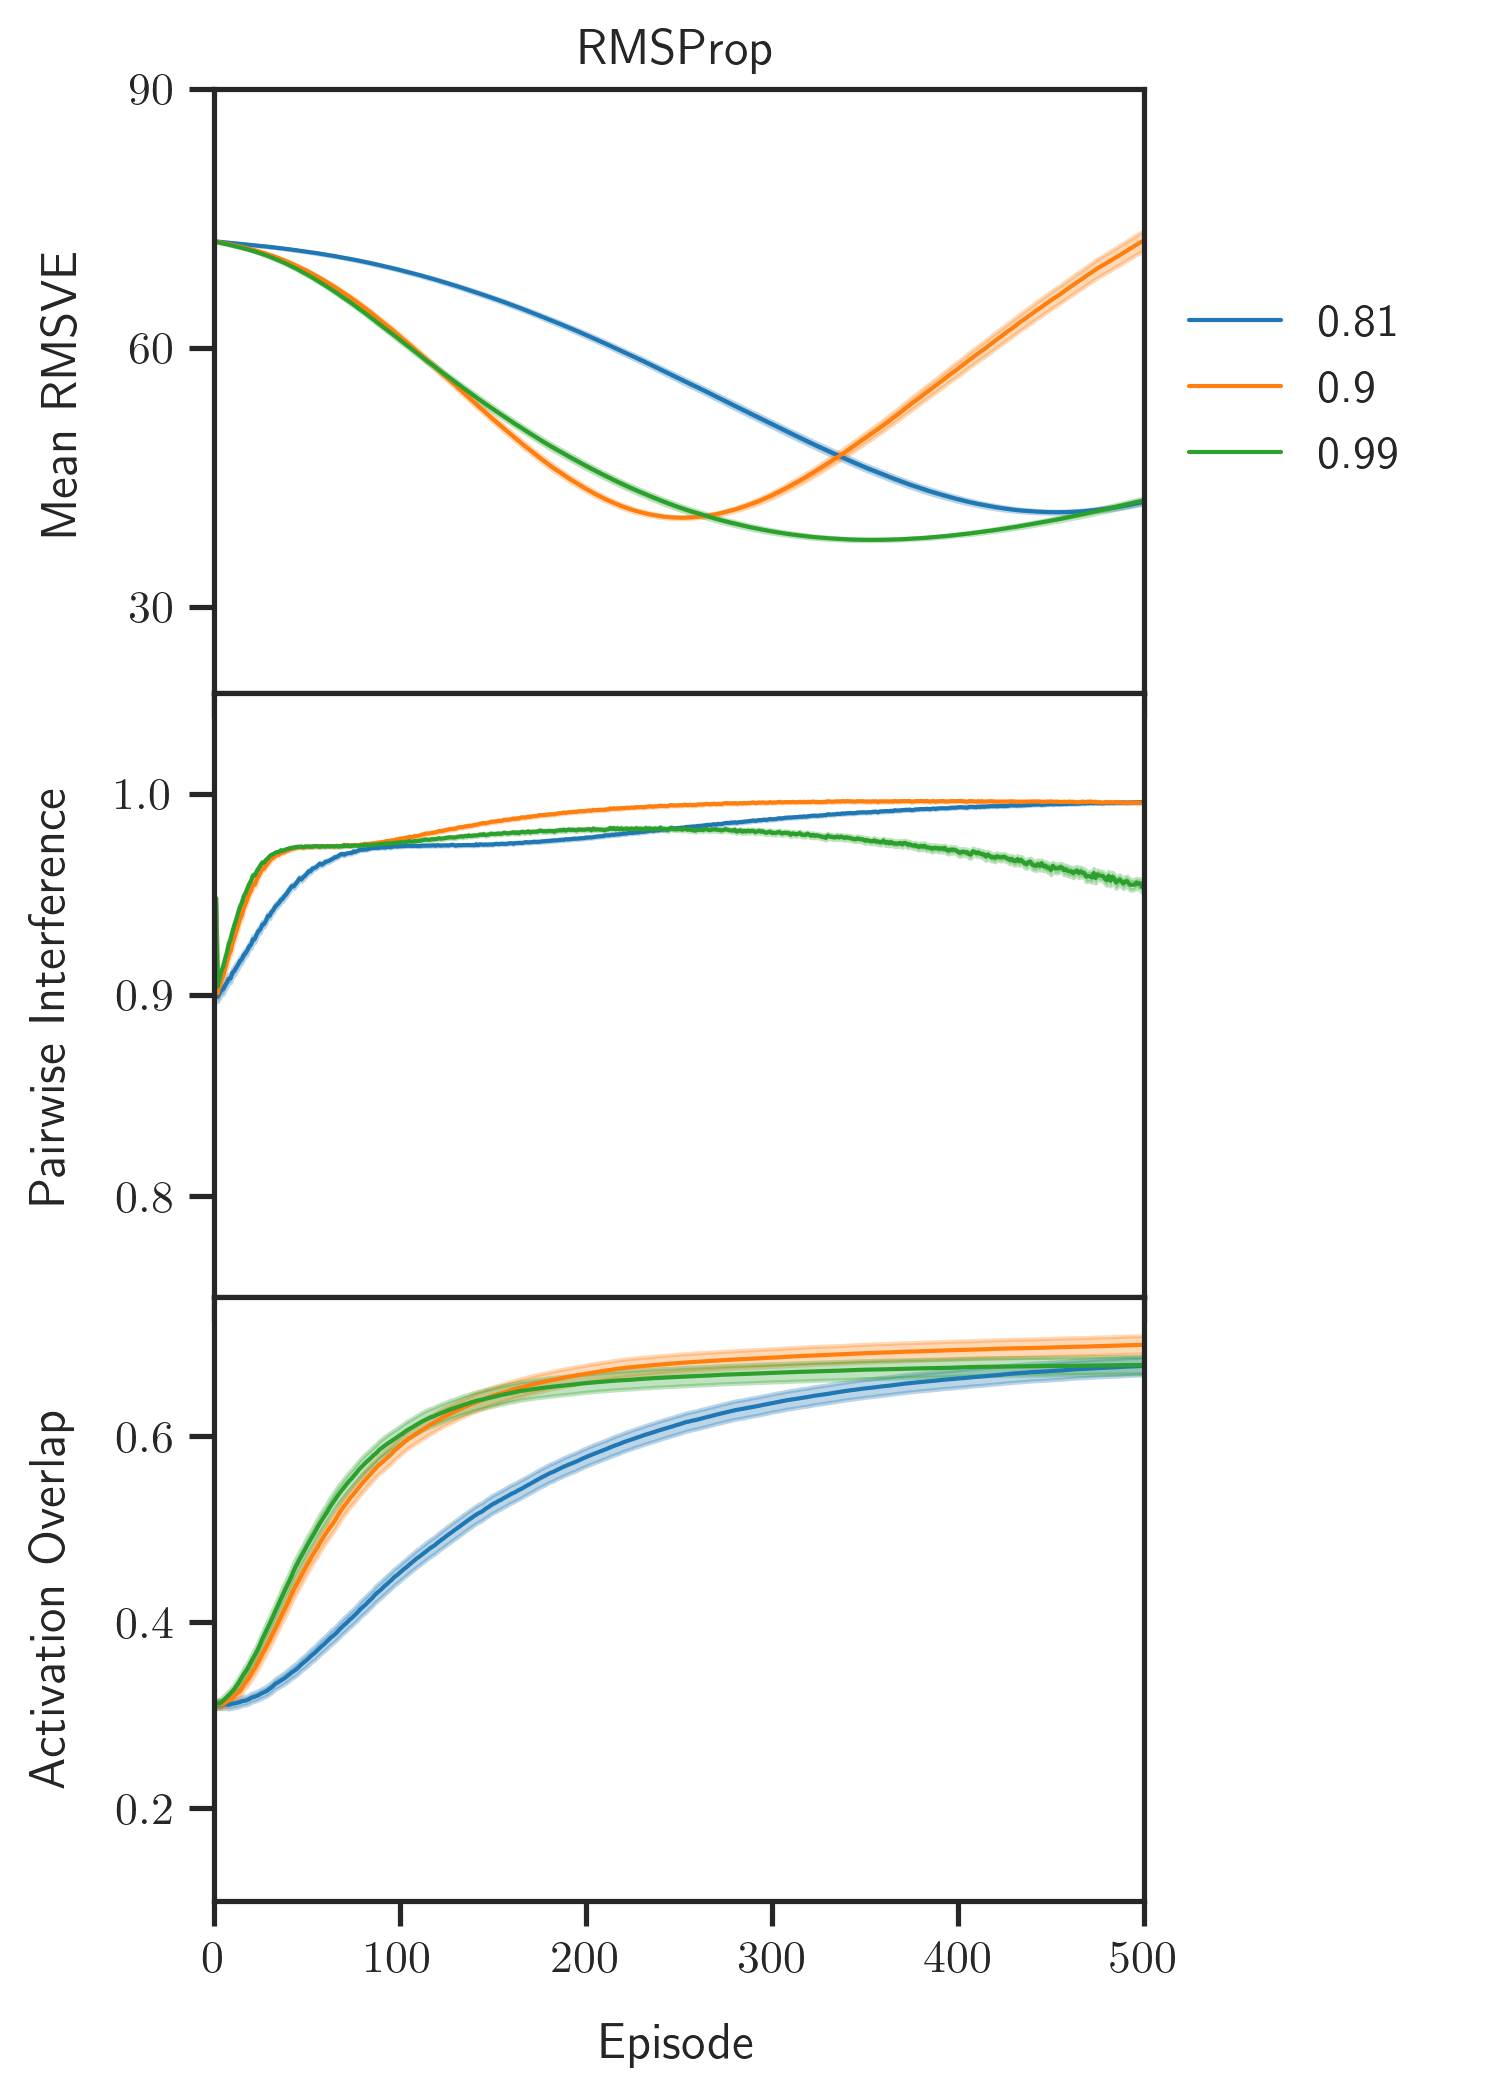

In [8]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('RMSProp')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.20, 0.765), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('mountain_car_rms_results.pdf', bbox_inches='tight')

# Test

In [9]:
data = load_data(['2020-05-28T13:56:24.485607-04:00.json'])
best = get_best(data, 'auc')
best_by_optimizer = get_best_by_optimizer(data, best)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best, best_by_optimizer)
best.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr,final_accuracy_mean,final_accuracy_stderr
0,constant,NaN,NaN,None,None,NaN,NaN,constant,NaN,NaN,500,19721.601296,0.613980,19721.601296,0.613980
1,neural_network,0.9,0.999,None,TD,0.031250,NaN,adam,NaN,1.0,500,17104.999302,32.618651,17104.999302,32.618651
2,neural_network,NaN,NaN,None,TD,0.000122,0.81,momentum,NaN,1.0,500,17317.303675,20.222734,17317.303675,20.222734
3,neural_network,NaN,NaN,None,TD,0.000488,0.00,sgd,NaN,1.0,500,17852.421709,23.516637,17852.421709,23.516637
4,neural_network,NaN,NaN,None,TD,0.000061,NaN,rms,0.99,1.0,500,24165.453449,13.296661,24165.453449,13.296661


## H12

In [10]:
constant = [item['final_accuracy'] for item in best_by_optimizer['constant']]
sgd = [item['final_accuracy'] for item in best_by_optimizer['sgd']]
print('Constant: {0:.4f}+-{1:.4f}\nSGD: {2:12.4f}+-{3:.4f}'.format(
    np.mean(constant),
    np.std(constant) / np.sqrt(len(constant)),
    np.mean(sgd),
    np.std(sgd) / np.sqrt(len(sgd))))
h12_t, h12_p = st.ttest_ind(constant, sgd)
print('H12: {} with p = {}'.format(
    'Reject' if h12_p < 0.05 else 'Fail to Reject', h12_p))
print()
print('h12_p = ', json.dumps(h12_p))

Constant: 39.2655+-0.0006
SGD:      27.5762+-0.2097
H12: Reject with p = 2.1431059654072486e-308

h12_p =  2.1431059654072486e-308


## H19

In [11]:
mean_activation_overlap = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_activation_overlap[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['activation_overlap']
        mean_activation_overlap[optimizer].append(np.mean(values))
for k,v in mean_activation_overlap.items():
    print('{0}: {1:.4f}+-{2:.4f}'.format(
        optimizer_nice_names[k],
        np.mean(v),
        np.std(v) / np.sqrt(len(v))))
print()
h19_t, h19_p = st.f_oneway(* mean_activation_overlap.values())
print('H19: {} with p = {}'.format(
    'Reject' if h19_p < 0.05 else 'Fail to Reject', h19_p))
print()
print('h19_p = ', json.dumps(h19_p))
print()
df = {'optimizer': list(), 'mean_activation_overlap': list()}
for k, v in mean_activation_overlap.items():
    df['mean_activation_overlap'] += v
    df['optimizer'] += [k] * len(v)
df = pd.DataFrame(df)
h19_tukey = str(MultiComparison(df['mean_activation_overlap'], df['optimizer']).tukeyhsd(0.05 / 20 - 1e-9).summary())
print(h19_tukey)
with open('h19_tukey.txt', 'w') as outfile:
    print(h19_tukey, file=outfile)

Momentum: 0.5549+-0.0027
RMSProp: 0.6059+-0.0028
SGD: 0.5552+-0.0026
Adam: 0.2494+-0.0020

H19: Reject with p = 0.0

h19_p =  0.0

 Multiple Comparison of Means - Tukey HSD, FWER=0.00  
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
    adam momentum   0.3055 0.001  0.2928 0.3182   True
    adam      rms   0.3565 0.001  0.3438 0.3692   True
    adam      sgd   0.3057 0.001   0.293 0.3185   True
momentum      rms    0.051 0.001  0.0383 0.0637   True
momentum      sgd   0.0003   0.9 -0.0124  0.013  False
     rms      sgd  -0.0508 0.001 -0.0635 -0.038   True
------------------------------------------------------


## H20

In [12]:
mean_pairwise_interference = dict()
for optimizer in list(set(best_by_optimizer.keys()) - {'constant'}):
    mean_pairwise_interference[optimizer] = list()
    for i in range(len(best_by_optimizer[optimizer])):
        values = best_by_optimizer[optimizer][i]['pairwise_interference']
        mean_pairwise_interference[optimizer].append(np.mean(values))
for k,v in mean_pairwise_interference.items():
    print('{0}: {1:.4f}+-{2:.4f}'.format(
        optimizer_nice_names[k],
        np.mean(v),
        np.std(v) / np.sqrt(len(v))))
print()
h20_t, h20_p = st.f_oneway(* mean_pairwise_interference.values())
print('H20: {} with p = {}'.format(
    'Reject' if h20_p < 0.05 else 'Fail to Reject', h20_p))
print()
print('h20_p =', json.dumps(h20_p))
print()
df = {'optimizer': list(), 'mean_pairwise_interference': list()}
for k, v in mean_pairwise_interference.items():
    df['mean_pairwise_interference'] += v
    df['optimizer'] += [k] * len(v)
df = pd.DataFrame(df)
h20_tukey = str(MultiComparison(df['mean_pairwise_interference'], df['optimizer']).tukeyhsd(0.05 / 20 - 1e-9).summary())
print(h20_tukey)
with open('h20_tukey.txt', 'w') as outfile:
    print(h20_tukey, file=outfile)

Momentum: 0.9174+-0.0004
RMSProp: 0.9738+-0.0002
SGD: 0.9188+-0.0004
Adam: 0.9091+-0.0004

H20: Reject with p = 0.0

h20_p = 0.0

  Multiple Comparison of Means - Tukey HSD, FWER=0.00   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
    adam momentum   0.0083  0.001  0.0065  0.0102   True
    adam      rms   0.0647  0.001  0.0628  0.0665   True
    adam      sgd   0.0097  0.001  0.0078  0.0115   True
momentum      rms   0.0563  0.001  0.0545  0.0582   True
momentum      sgd   0.0013 0.0497 -0.0005  0.0032  False
     rms      sgd   -0.055  0.001 -0.0568 -0.0532   True
--------------------------------------------------------


## Plotting

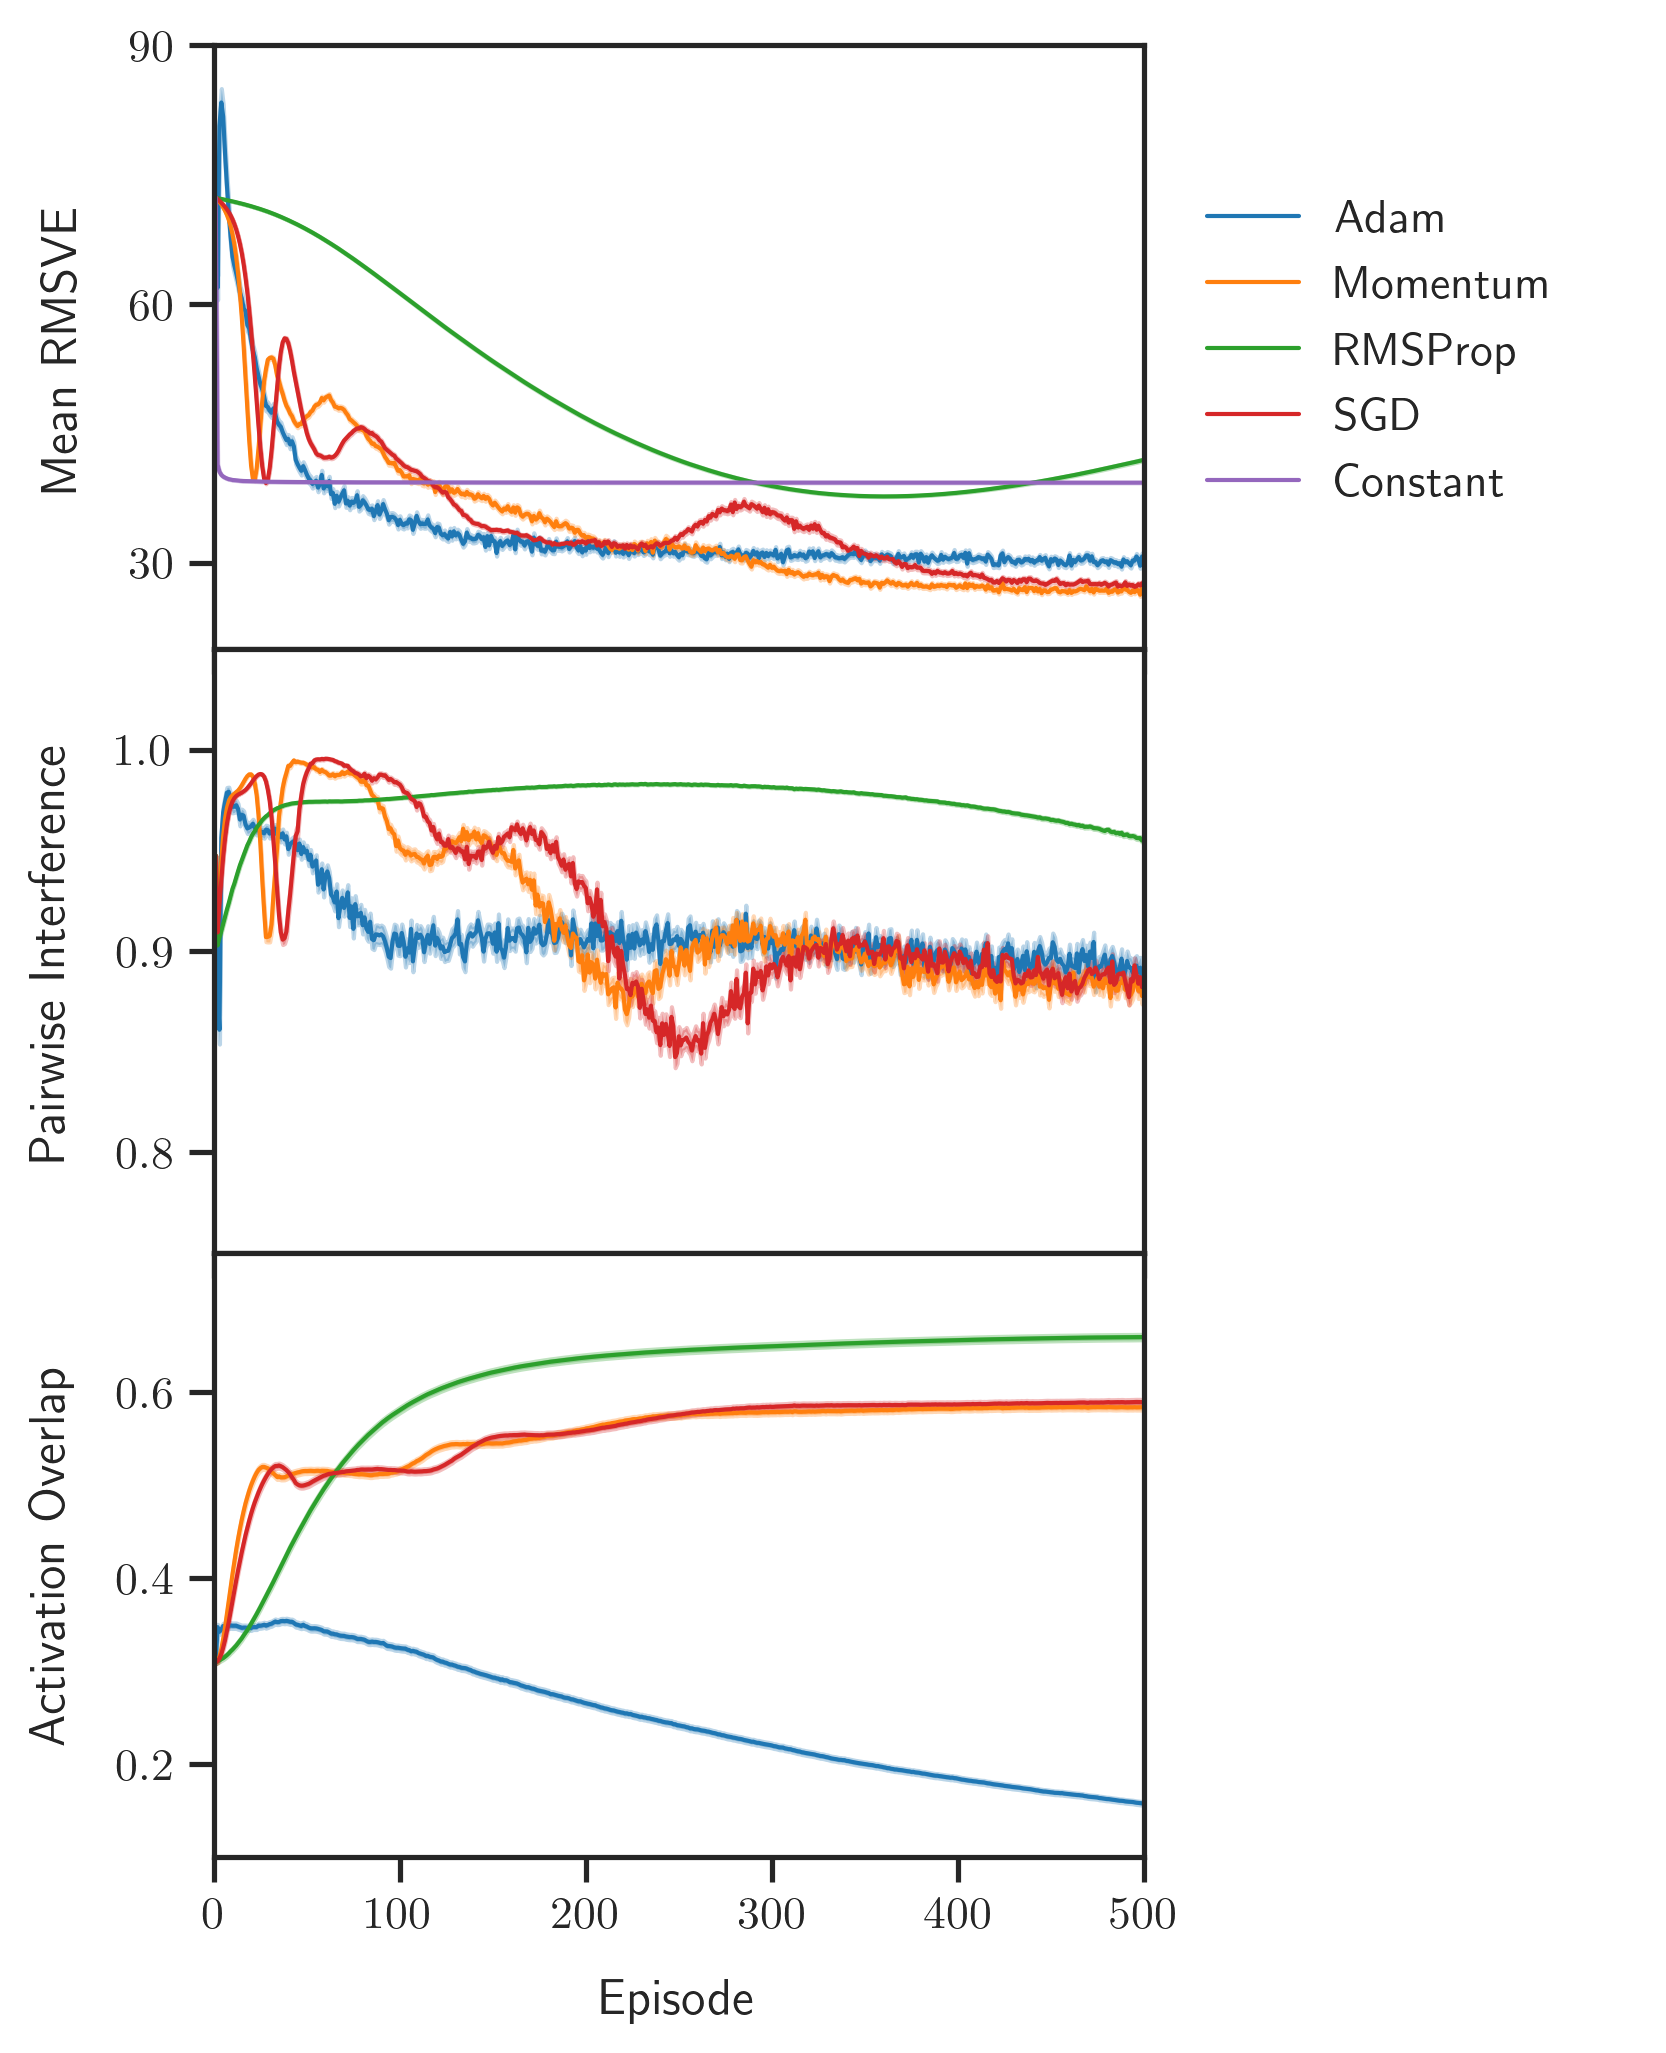

In [13]:
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer_nice_names[optimizer],
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.75, 1.05)
ax2.set_yticks([0.8, 0.9, 1.0])
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.1, 0.75)
ax3.set_yticks([0.2, 0.4, 0.6])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.79), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('mountain_car_results.pdf', bbox_inches='tight')